<center><h1> Auto Diesel Platts Price Forecasting using LSTM model

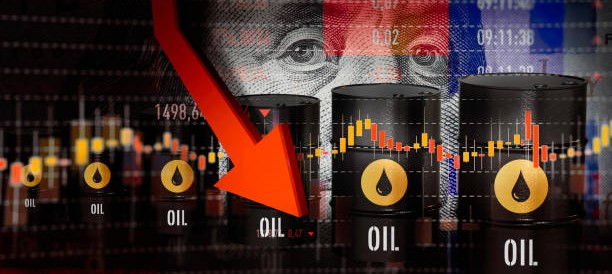

## Import packages

In [1]:
import pandas as pd
import quandl
import numpy as np 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import math
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from IPython.display import Image
import seaborn as sns

## Data cleaning and Data Preparation

In [2]:
data_set_Auto_Diesel = pd.read_csv('C:\\Users\\acer\\Desktop\\auto_diesel.csv')# import data set
data_set_Auto_Diesel.head()

,date,AutoDiesel_price
0,1/4/2010,85.55
1,1/5/2010,87.73
2,1/6/2010,88.16
3,1/7/2010,89.32
4,1/8/2010,89.18


## Auto Diesel Platts Price vs Time

<function matplotlib.pyplot.show(close=None, block=None)>

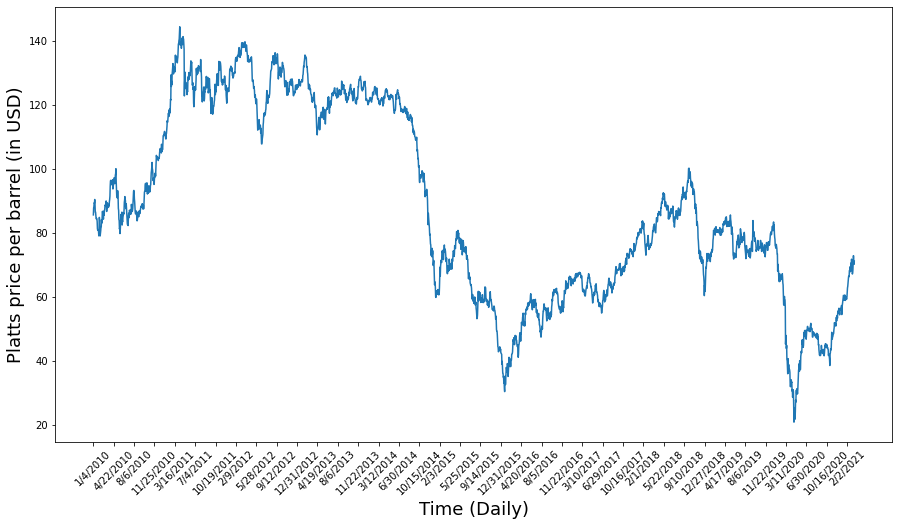

In [3]:
# Auto Diesel Platts Price plot
plt.gcf().set_size_inches(15, 8, forward=True)
plt.plot(range(data_set_Auto_Diesel.shape[0]),(data_set_Auto_Diesel['AutoDiesel_price']), '')
plt.xticks(range(0,data_set_Auto_Diesel.shape[0],75),data_set_Auto_Diesel['date'].loc[::75],rotation=45)
plt.xlabel('Time (Daily)',fontsize=18)
plt.ylabel('Platts price per barrel (in USD)',fontsize=18)
plt.show

## descriptive statistics

<b><ul><li>Box plot

<AxesSubplot:>

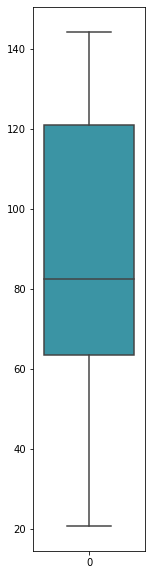

In [4]:
colors_list_1 = ['#29a0b6', '#e793b0']
colors_list_2 = ['#29a0b6', '#e793b0']
fig = plt.figure(figsize=(2,10))
sns.boxplot(data=data_set_Auto_Diesel.AutoDiesel_price, palette=colors_list_1)


#### Get the Daily log return series

In [5]:
data_set_Auto_Diesel['Daily_return_log'] = np.log10(data_set_Auto_Diesel['AutoDiesel_price']
                                                  /data_set_Auto_Diesel['AutoDiesel_price'].shift(1))

In [6]:
data_set_Auto_Diesel_df = data_set_Auto_Diesel.dropna() #remove NaN values
data_set_Auto_Diesel_df.head()

,date,AutoDiesel_price,Daily_return_log
1,1/5/2010,87.73,0.010928
2,1/6/2010,88.16,0.002123
3,1/7/2010,89.32,0.005677
4,1/8/2010,89.18,-0.000681
5,1/11/2010,90.37,0.005757


## Data Exploration

In [7]:
data_set_Auto_Diesel_df.describe() #summary of data set

,AutoDiesel_price,Daily_return_log
count,2801.000000,2801.000000
mean,88.026437,-0.000029
std,29.712492,0.008849
min,20.750000,-0.099061
25%,63.490000,-0.003949
50%,82.440000,0.000138
75%,120.980000,0.004074
max,144.370000,0.084899


## Auto Diesel Platts Price Return vs Time

<function matplotlib.pyplot.show(close=None, block=None)>

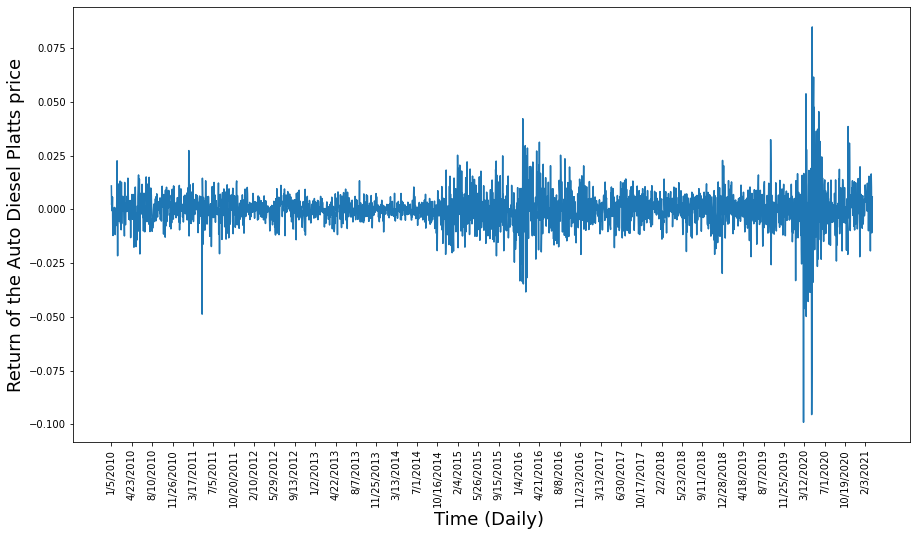

In [8]:
# Auto Diesel Platts Price plot
plt.gcf().set_size_inches(15, 8, forward=True)

plt.plot(range(data_set_Auto_Diesel_df.shape[0]),(data_set_Auto_Diesel_df['Daily_return_log']))

plt.xticks(range(0,data_set_Auto_Diesel_df.shape[0],75),data_set_Auto_Diesel_df['date'].loc[::75],rotation=90)

plt.xlabel('Time (Daily) ',fontsize=18)
plt.ylabel('Return of the Auto Diesel Platts price',fontsize=18)
plt.show

### <b><ul><li>squared return

<function matplotlib.pyplot.show(close=None, block=None)>

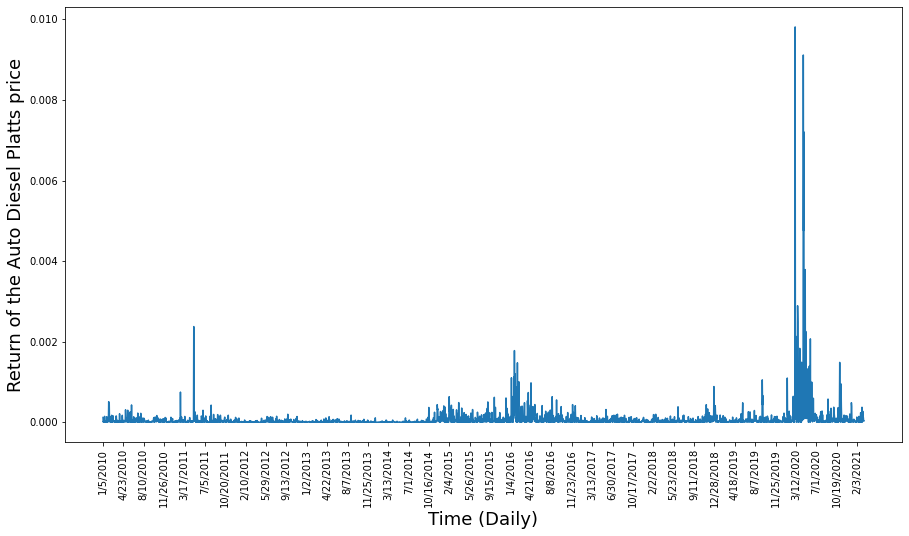

In [9]:
# Auto Diesel Platts Price plot
plt.gcf().set_size_inches(15, 8, forward=True)

plt.plot(range(data_set_Auto_Diesel_df.shape[0]),(data_set_Auto_Diesel_df['Daily_return_log'].pow(2)))

plt.xticks(range(0,data_set_Auto_Diesel_df.shape[0],75),data_set_Auto_Diesel_df['date'].loc[::75],rotation=90)

plt.xlabel('Time (Daily)',fontsize=18)
plt.ylabel('Return of the Auto Diesel Platts price',fontsize=18)
plt.show

In [10]:
# Create  a new dataframe with only ''Daily_return_log' 
data_set_Auto_Diesel_new_1 = data_set_Auto_Diesel_df.filter(['Daily_return_log'])
data_set_Auto_Diesel_new_1.head()

,Daily_return_log
1,0.010928
2,0.002123
3,0.005677
4,-0.000681
5,0.005757


## Data Normalization
Normalization is a rescaling of the data from the original range so that all values are within the range of 0 and 1.

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_set_Auto_scaler = scaler.fit_transform(data_set_Auto_Diesel_new_1)
print(data_set_Auto_scaler)

[[0.59789588]
 [0.55003402]
 [0.56935171]
 ...
 [0.47905303]
 [0.50836967]
 [0.57027452]]


## Select the Training , Validation and Test sets

In [12]:
train_data = data_set_Auto_scaler[:1804] #Select Training sets
val_data = data_set_Auto_scaler[1804:2004] #Select Validation sets
test_data = data_set_Auto_scaler[2004:] #Select Test sets

print(train_data.shape)
print(val_data.shape)
print(test_data.shape,'\n')

data = data_set_Auto_Diesel["date"]
print("Test dates:", data[1] ," to", data[1804] ,'\n')
print('Validation dates:', data[1805] ," to", data[2002],'\n')
print('Train dates: ', data[2003] ," to", data[2801] )

(1804, 1)
(200, 1)
(797, 1) 

Test dates: 1/5/2010  to 3/16/2017 

Validation dates: 3/17/2017  to 12/29/2017 

Train dates:  1/2/2018  to 3/11/2021


In [13]:
# Reshape the data into 3-D array
time_steps = 1 # define time_steps = 1. 

X_train = np.array([train_data[i : i + time_steps].copy() for i in range(len(train_data) - time_steps)])

y_train = np.array([train_data[:,0][i + time_steps].copy() for i in range(len(train_data) - time_steps)])

X_test = np.array([test_data[i : i + time_steps].copy() for i in range(len(test_data) - time_steps)])

y_test = np.array([test_data[:,0][i + time_steps].copy() for i in range(len(test_data) - time_steps)]) 

val_x_data =  np.array([val_data[i : i + time_steps].copy() for i in range(len(val_data) - time_steps)])
val_y_data =  np.array([val_data[:,0][i + time_steps].copy() for i in range(len(val_data) - time_steps)]) 

## Defining the LSTM model

In [14]:
#  define network
lstm_input = Input(shape=(time_steps, 1), name='lstm_input')

#First LSTM hidden layer with contains 80 neurons.
inputs = LSTM(80, name='Fifth_layer', return_sequences = True)(lstm_input)
inputs = Dropout(0.2)(inputs)

#Second LSTM hidden layer with contains 80 neurons.
inputs = LSTM(80, name='Second_layer')(lstm_input)
inputs = Dropout(0.2)(inputs)

# output layer
inputs = Dense(1, name='first_dense_layer')(inputs)

output = Activation('tanh', name='output')(inputs) #select the 'tanh' as a activetion function

model = Model(inputs=lstm_input, outputs=output)

# compile network
adam = optimizers.Adam(lr=0.001)

model.compile(optimizer='adam', loss='mse')
## fit network
#set the parameters of epochs and batch_size to 60 and 45, respectively
history = model.fit(x=X_train, y=y_train, batch_size=60, epochs=40, shuffle=True, verbose=0,
                    validation_data= (val_x_data,val_y_data))

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 1, 1)]            0         
_________________________________________________________________
Second_layer (LSTM)          (None, 80)                26240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
first_dense_layer (Dense)    (None, 1)                 81        
_________________________________________________________________
output (Activation)          (None, 1)                 0         
Total params: 26,321
Trainable params: 26,321
Non-trainable params: 0
_________________________________________________________________


In [16]:
train_evaluation = model.evaluate(X_train, y_train, verbose=0)
print(train_evaluation)

0.0016891427803784609


In [17]:
# evaluate network
test_evaluation = model.evaluate(X_test, y_test, verbose=0)
print(test_evaluation)

0.004683891776949167


## model train vs validation loss

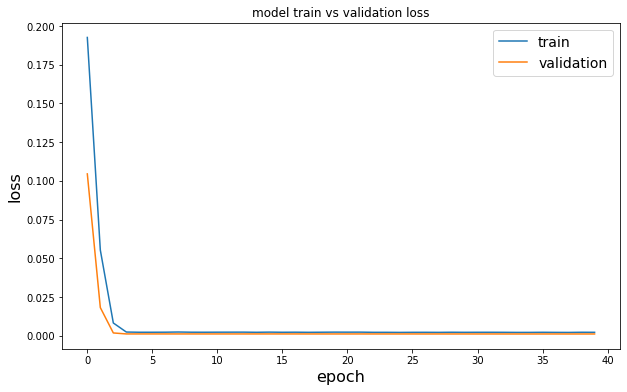

In [18]:
plt.gcf().set_size_inches(10,6, forward=True)

pyplot.plot(history.history['loss'])

pyplot.plot(history.history['val_loss'])

pyplot.title('model train vs validation loss', fontsize=12)

pyplot.ylabel('loss', fontsize=16)
pyplot.xlabel('epoch', fontsize=16)

pyplot.legend(['train', 'validation'], loc='upper right', fontsize=14)
pyplot.show()

## Test data vs Predicted data (Return Series)

<b><ul><li> Predicted data

In [19]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_pred = np.round(y_pred, 8)
y_pred[:10]

array([[ 1.72374e-03],
       [-8.19410e-04],
       [-9.80080e-04],
       [-1.63710e-04],
       [ 1.03855e-03],
       [-2.92560e-04],
       [-1.65360e-04],
       [ 7.02710e-04],
       [ 8.45000e-05],
       [-8.95780e-04]], dtype=float32)

<b><ul><li> Test data

In [20]:
#Processing test shape
y_test = np.array(y_test).reshape(-1,1)
y_test = scaler.inverse_transform(y_test)
y_test = np.round(y_test, 8)
y_test[:10]

array([[-0.00201327],
       [-0.0026258 ],
       [ 0.00049355],
       [ 0.00512159],
       [ 0.        ],
       [ 0.00048721],
       [ 0.00382451],
       [ 0.0014456 ],
       [-0.00230452],
       [-0.00091447]])

## Visualization

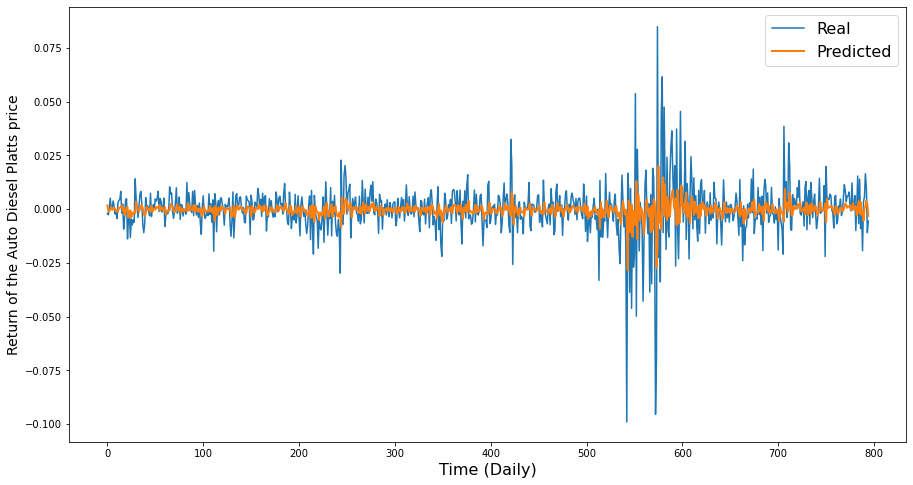

In [21]:
plt.gcf().set_size_inches(15, 8, forward=True)

start = 0
end = -1

real = plt.plot(y_test[start:end], label='real')
pred = plt.plot(y_pred[start:end], label='predicted',linewidth=2)

plt.legend(['Real', 'Predicted'],fontsize=16)

pyplot.ylabel('Return of the Auto Diesel Platts price', fontsize=14)
pyplot.xlabel('Time (Daily)', fontsize=16)

plt.show()

## Evaluation matrix (Return Series)

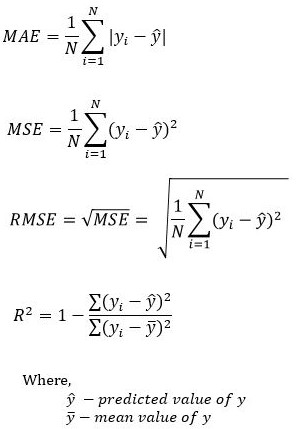

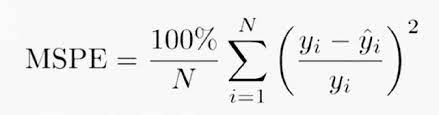

In [22]:
print('====================================')
print('| R2 Score |', r2_score(y_pred, y_test),'  |')
print('____________________________________')
print('| MSE      |', mean_squared_error(y_pred, y_test),' |')
print('____________________________________')
MSE =  mean_squared_error(y_pred, y_test)
print('| RMSE     |', math.sqrt(MSE),' |')
print('____________________________________')
print('| MAE      |', mean_absolute_error(y_pred, y_test),' |')
print('====================================')

| R2 Score | -14.76872081604179   |
____________________________________
| MSE      | 0.00015850872547491313  |
____________________________________
| RMSE     | 0.012590024840122959  |
____________________________________
| MAE      | 0.007792227795042226  |


## Test data vs Predicted data (Original Series)

In [23]:
# Scaled data transform into Original data
price = np.array(data_set_Auto_Diesel_df.filter(['AutoDiesel_price']).shift(1))
price = price[2005:]

<b><ul><li> Test data

In [24]:
res_y_test = (10**y_test)
res_y_test = res_y_test*price
res_y_test[:10]

array([[79.63000023],
       [79.14999937],
       [79.24000043],
       [80.18000091],
       [80.18      ],
       [80.2699998 ],
       [80.9800001 ],
       [81.25000052],
       [80.82000066],
       [80.65000081]])

<b><ul><li> Predicted data

In [25]:
res_y_pred = (10**y_pred)
res_y_pred = res_y_pred*price
res_y_pred[:10]

array([[80.31815529],
       [79.4798977 ],
       [78.97158101],
       [79.21013602],
       [80.37196691],
       [80.12600572],
       [80.23944162],
       [81.11113407],
       [81.26580715],
       [80.65347257]])

## Visualization (Original Series)

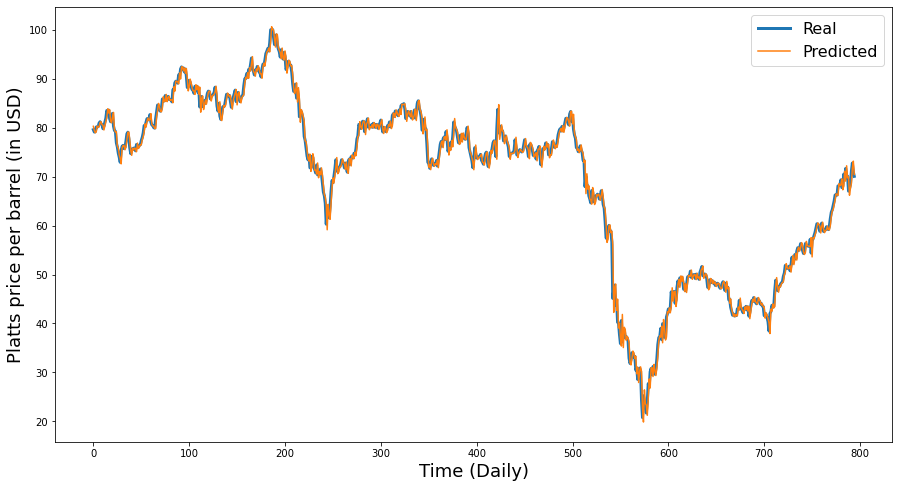

In [26]:
plt.gcf().set_size_inches(15, 8, forward=True)

start = 0
end = -1

res_real = plt.plot(res_y_test[start:end], label='real', linewidth= 3)
res_pred = plt.plot(res_y_pred[start:end], label='predicted')

plt.legend(['Real', 'Predicted'], fontsize=16)

pyplot.ylabel('Platts price per barrel (in USD)', fontsize=18)
pyplot.xlabel('Time (Daily)', fontsize=18)

plt.show()

## Evaluation matrix

In [27]:
print('====================================')
print('| R2 Score |', r2_score(res_y_pred, res_y_test),' |')
print('____________________________________')
print('| MSE      |', mean_squared_error(res_y_pred, res_y_test),' |')
print('____________________________________')
MSE =  mean_squared_error(res_y_pred, res_y_test)
print('| RMSE     |', math.sqrt(MSE),' |')
print('____________________________________')
print('| MAE      |', mean_absolute_error(res_y_pred, res_y_test),' |')
print('____________________________________')
print('|MSPE      |', (np.mean(np.square((res_y_test - res_y_pred) / res_y_test))) * 100, '|')
print('____________________________________')
print('|RMSPE     |',  (np.sqrt(np.mean(np.square((res_y_test - res_y_pred) / res_y_test)))) * 100,' |')
print('====================================')

| R2 Score | 0.9929556261157169  |
____________________________________
| MSE      | 2.1347706574164387  |
____________________________________
| RMSE     | 1.4610854380960885  |
____________________________________
| MAE      | 1.0742630412908276  |
____________________________________
|MSPE      | 0.08511178985770641 |
____________________________________
|RMSPE     | 2.917392497723034  |


In [57]:
# create a Predicted data array
arr = np.zeros(shape=(2004,1))
arr = arr.astype('float')
arr[arr==0]='nan'

pre_arr=np.array(res_y_pred-0.85)

pred_arr = np.append(arr, pre_arr)

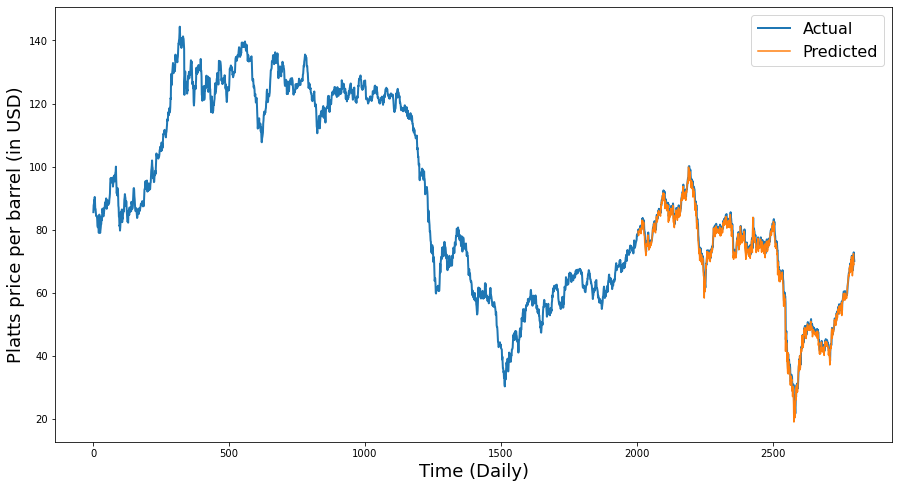

In [66]:
fig, ax = plt.subplots()
fig.set_size_inches(15,8, forward=True)

g_train_data = data_set_Auto_Diesel[:2801] #Select Training sets
#g_val_data = data_set_Auto_Diesel[1804:2001] #Select Training sets
#g_test_data = data_set_Auto_Diesel[2002:] #Select Test sets

plt.plot(g_train_data['AutoDiesel_price'], linewidth=2)# Train data grapha
#plt.plot(g_val_data['AutoDiesel_price'])# Train data grapha
#plt.plot(g_test_data['AutoDiesel_price'],linewidth=1.5, color='#F70D1A') # Test data grapha
plt.plot(pred_arr,linewidth=1.5) # Forecasting grapha

plt.legend(['Actual',  'Predicted'], fontsize=16)
plt.xlabel('Time (Daily)',fontsize=18)
plt.ylabel('Platts price per barrel (in USD)',fontsize=18)
#plt.axvline(x=1804)
#plt.axvline(x=2001)
plt.show()

# 

=============================  *** ==============================

# 

<h2><center>Platts price of Auto Diesel forecasting methodology

<b>Inputs :</b> historical Platts price of Auto Diesel data - Return of the Auto Diesel Platts price (04-01-2010/ 11-03-2021)<p>
<b>Output :</b> predicted Platts price of Auto Diesel data


<b>methodology :</b>
1.	Input data
2.	Data cleaning and Data Preparation
3.	Plot the time series plot
4.	Calculate descriptive statistics
5.	The input variables are scaled to a standard range of (0, 1) to perform a better ANN learning algorithm. (Data Normalizing)


6.	Input data set spilt into Training, validation and Testing set 

|<center>Split of data set|<center>Time period|
|---------------|--------------------|
|Training set	|5th January 2010 to 16th March 2017. (1801 observations)|
|
|Validation set	|17th March 2017 to 29th December 2017. (200 observations)|
|
|Testing set 	|02nd January 2018 to 11th March 2021 (800 observations)|



7.	Data is stored in a numpy array of three dimensions (p, q, r)
<ul><li><b>p – </b> Number of training sequences. (1801)
<li><b>q – </b>sequence length or time split(1)
<li><b>r – </b>number of features of each sequences (1)



8.	LSTM Model the architecture
<ul><li>Define the 2, LSTM hidden layer with 80 neurons and 1 neuron in the output layer. 
<li>The input shape is 1 time step.
<li>Dropout 20%.
<li>Use the MSE loss function and the Adam stochastic gradient descent optimizer.
<li>Activation function is <b>tanh</b>
<li>The model will be fit for 40 training epochs with a batch size of 60.


9.	loss function

10.	Prediction (data forecast)

11.	Evaluation matrix

# 

=============================  *** ==============================

# 

<center><h3> LSTM vs GARCH forecasting accuracy comparison


|<center>Coefficient|	<center>LSTM|<center>GARCH(2,1) |
|-----------|---------|-----------|
|MSE (Mean Square Error)|	0.0001570507 |       0.000764246|
|||
|MAE (Mean Absolute Error)|	0.007757660|   0.017045|
|||
|RMSE (Root Mean Square Error)|	0.0125319879|    0.027645|


# 

=============================  *** ==============================

# 

## Reference

<ul><li> research and publications

[1] https://www.irjet.net/archives/V5/i3/IRJET-V5I3788.pdf

[2] https://www.researchgate.net/publication/348390803_Stock_Price_Prediction_Using_LSTM

[3] Ogus D.(2019).Long Short-Term Memory: Can Artificial 
Neural Networks beat Econometric Models?.

<ul><li> online publications

[1] https://colah.github.io/posts/2015-08-Understanding-LSTMs/

[2] https://datascienceplus.com/long-short-term-memory-lstm-and-how-to-implement-lstm-using-python/

[3] https://towardsdatascience.com/getting-rich-quick-with-machine-learning-and-stock-market-predictions-696802da94fe

[4] https://medium.com/analytics-vidhya/analysis-of-stock-price-predictions-using-lstm-models-f993faa524c4

[5] https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/



<ul><li> Youtube  resources

[1] https://www.youtube.com/watch?v=QIUxPv5PJOY&t=2471s

[2] https://www.youtube.com/watch?v=LfnrRPFhkuY

[3] https://www.youtube.com/watch?v=UbvkhuqVqUI&t=926s


=============================  *** ==============================

# 